# Import Libraries

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from helpers import parse_variables, get_risk_level, hi_gauss_blob_risk_fun, blob_risk_fun, NW_risk_fun, square_risk_fun, simulate_cc_status
from matplotlib.colors import LinearSegmentedColormap
import importlib.util

# Load populations

In [3]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
if 'k' not in globals():
    k = int(dict['k'])
    
if 'M' not in globals():
    M = float(dict['M'])
HWE = int(dict['HWE'])

In [4]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/phenotype/01_population_structure.pkl")
populations

FileNotFoundError: [Errno 2] No such file or directory: 'data/G50_L50_c50_k2_M0.1_HWE1/phenotype/01_population_structure.pkl'

# create risk

In [4]:
existing_risks = [
    "no_risk_fun",
    "NW_risk_fun",
    "N_risk_fun",
    "blob_risk_fun",
    "center_risk_fun",
    "big_square_risk_fun",
    "square_risk_fun",
    "hi_square_risk_fun",
    "mid_square_risk_fun",
    "mid_mid_square_risk_fun",
    "mid_mid_mid_square_risk_fun",
    "big_bad_square_risk_fun",
    "big_square_risk_fun_updated",
    "big_big_square_risk_fun",
    "big_big_big_square_risk_fun",
    "two_square_risk_fun",
    "three_square_risk_fun",
    "four_square_risk_fun",
    "as_big_blob_risk_fun",
    "six_square_risk_fun",
    "gauss_blob_risk_fun",
    "hi_gauss_blob_risk_fun"
]

In [1]:
# Dynamically import the function based on the risk level
module_name = 'helpers'
module_spec = importlib.util.spec_from_file_location(module_name, 'helpers.py')
helpers = importlib.util.module_from_spec(module_spec)
module_spec.loader.exec_module(helpers)

for risk in existing_risks:
    risk_function = getattr(helpers, risk)
    name_risk = risk.split('_fun')[0]
    populations['x_temp'] = populations['x']/k
    populations['y_temp'] = populations['y']/k
    populations[name_risk] = list(populations.apply(lambda row: risk_function(row['x_temp'], row['y_temp']), axis=1))
    populations[name_risk] = populations[name_risk].astype('float')
    os.makedirs(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/phenotype/environmental_risks/", exist_ok=True)
    populations[[name_risk]].to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/phenotype/environmental_risks/risk_{name_risk}.pkl")
    # Create subplots for each risk
    fig, axs = plt.subplots(1, 1, figsize=(14, 12))
    # Aggregate by x and y and calculate mean for each risk
    df_agg = populations.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
    grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
    sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)
    
    # Set the title dynamically based on the value of name_risk
    axs.set_title(name_risk, fontsize=16)
    
    # Invert the y-axis
    axs.invert_yaxis()
    
    # Adjust layout
    plt.tight_layout()
    #plt.show()
    plt.close()

NameError: name 'importlib' is not defined

# Visualise some examples

In [6]:
populations['gauss_blob_risk'] = list(populations.apply(lambda row: hi_gauss_blob_risk_fun(row['x_temp'], row['y_temp']), axis=1))
populations['gauss_blob_risk'] = populations['gauss_blob_risk'].astype('float')

populations['blob_risk'] = list(populations.apply(lambda row: blob_risk_fun(row['x_temp'], row['y_temp']), axis=1))
populations['blob_risk'] = populations['blob_risk'].astype('float')

populations['NW_risk'] = list(populations.apply(lambda row: NW_risk_fun(row['x_temp'], row['y_temp']), axis=1))
populations['NW_risk'] = populations['NW_risk'].astype('float')

populations['square_risk'] = list(populations.apply(lambda row: square_risk_fun(row['x_temp'], row['y_temp']), axis=1))
populations['square_risk'] = populations['square_risk'].astype('float')

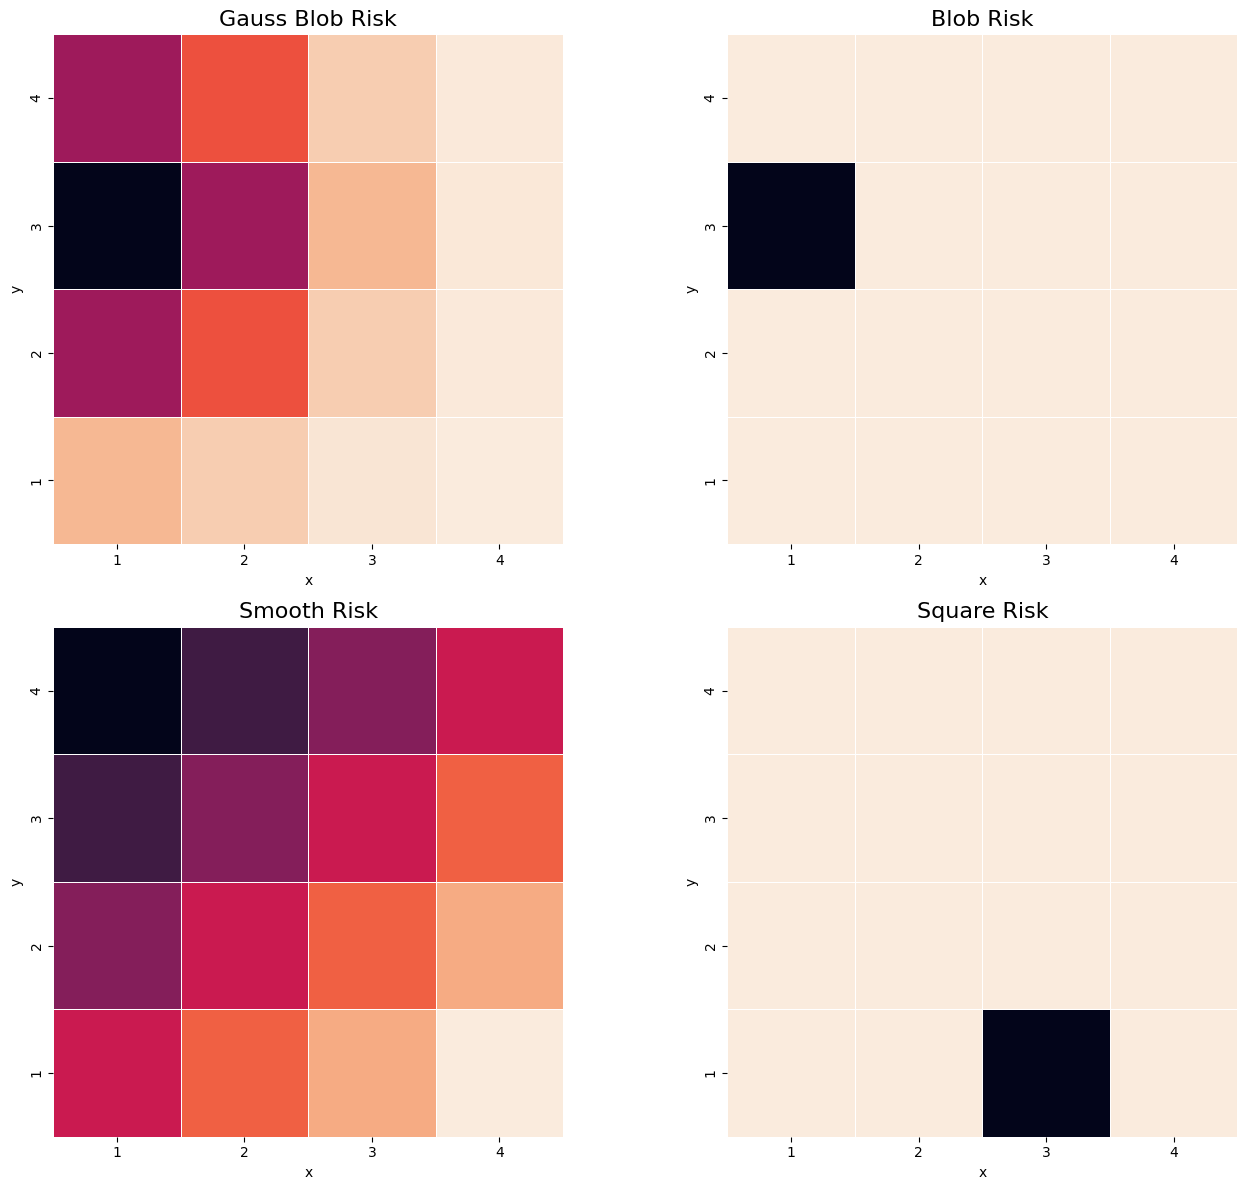

In [7]:
# Aggregate by x and y and calculate mean for each risk
df_agg = populations.groupby(['x', 'y']).agg({'gauss_blob_risk': 'mean', 
                                     'blob_risk': 'mean', 
                                     'NW_risk': 'mean', 
                                     'square_risk': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame for each risk
grid_df_gauss_blob = df_agg.pivot(index='y', columns='x', values='gauss_blob_risk')
grid_df_blob = df_agg.pivot(index='y', columns='x', values='blob_risk')
grid_df_hi_square = df_agg.pivot(index='y', columns='x', values='NW_risk')
grid_df_square = df_agg.pivot(index='y', columns='x', values='square_risk')

# Create subplots for each risk
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Plot for gauss_blob_risk
sns.heatmap(grid_df_gauss_blob, cmap='rocket_r', linewidths=.5, square=True, cbar=False, ax=axs[0, 0])
axs[0, 0].set_title('Gauss Blob Risk', fontsize=16)
axs[0, 0].invert_yaxis()

# Plot for blob_risk
sns.heatmap(grid_df_blob, cmap='rocket_r', linewidths=.5, square=True, cbar=False, ax=axs[0, 1])
axs[0, 1].set_title('Blob Risk', fontsize=16)
axs[0, 1].invert_yaxis()

# Plot for hi_square_risk
sns.heatmap(grid_df_hi_square, cmap='rocket_r', linewidths=.5, square=True, cbar=False, ax=axs[1, 0])
axs[1, 0].set_title('Smooth Risk', fontsize=16)
axs[1, 0].invert_yaxis()

# Plot for square_risk
sns.heatmap(grid_df_square, cmap='rocket_r', linewidths=.5, square=True, cbar=False, ax=axs[1, 1])
axs[1, 1].set_title('Square Risk', fontsize=16)
axs[1, 1].invert_yaxis()

# Adjust layout
plt.tight_layout()
#plt.show()
plt.close()